# Prevenção de Stroke - Acidente Vascular Cerebral(AVC) 

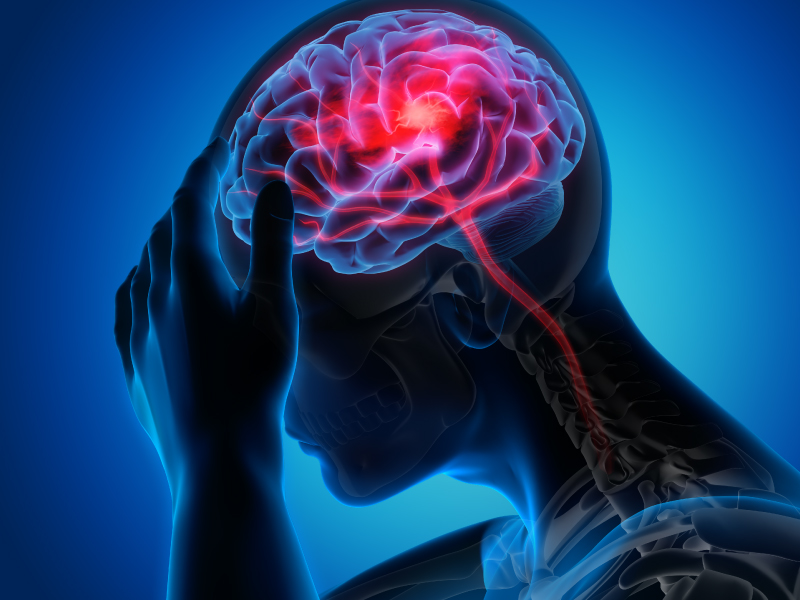

In [2]:
Image('https://raw.githubusercontent.com/rodrigogaf01/Stroke-Prediction/main/stroke.jpg', width= 700)

## Contexto 

O Acidente vascular cerebral (AVC), ou em inglês, stroke é a doença que mais mata no Brasil e a que mais causa incapacidade no mundo: cerca de 70% das pessoas que sofrem um derrame não retorna ao trabalho depois do acidente vascular cerebral e 50% ficam dependentes de outras pessoas no dia a dia. Apesar desses números preocupantes, muita gente ainda têm dúvidas sobre o assunto e desconhece as principais causas, sintomas e maneiras de prevenir essa enfermidade.

O AVC acontece quando o suprimento de sangue que vai para o cérebro é interrompido ou drasticamente reduzido, privando as cédulas de oxigênio e de nutrientes. Ou, então, quando um vaso sanguíneo se rompe, causando uma hemorragia cerebral. Entre as causas dessas ocorrências, estão a malformação arterial cerebral (aneurisma), hipertensão arterial, cardiopatia, tromboembolia (bloqueio da artéria pulmonar).

### Problema

- Qual é o objetivo?

    * Construir um mode de Machine Learning capaz de prever se uma pessoa tende a ter um AVC.
    
    
- Por que é necessário?

     * É importante prestar atenção aos sintomas para saber identificar um AVC e procurar ajuda médica o mais rápido possível. Quanto mais cedo forem tratados o acidente vascular cerebral isquêmico e o acidente vascular cerebral hemorrágico, melhores são os prognósticos do paciente.
     
        
Na próxima etapa, construiremos nossa solução. Portanto, seguiremos todas essas etapas a seguir.

- 0.0. IMPORTS
- 1.0. DESCRIÇÃO DOS DADOS
- 2.0. FEATURE ENGINEERING
- 3.0. FILTRANDO OS DADOS
- 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS
- 5.0. PREPARAÇÃO DOS DADOS
- 6.0. SELEÇÃO DE FEATURES
- 7.0. MACHINE LEARNING
- 8.0. INTERPRETANDO OS RESULTADOS

## 0.0. IMPORTS

In [1]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import matplotlib.patches    as mpatches
import seaborn               as sns
from scipy                   import stats    as ss
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics         import classification_report, confusion_matrix
from imblearn.over_sampling  import SMOTE 
from sklearn.tree            import DecisionTreeClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier, AdaBoostClassifier
from xgboost                 import XGBClassifier
from IPython.display         import Image
import warnings

### 0.1. Funções de Ajuda

In [3]:
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

def titulo(title, y= 1):
    plt.title(title, fontsize= 20, color= 'grey', loc= 'left', fontweight= 'bold', y= y)

def labels(x, y):
    plt.xlabel(x)
    plt.ylabel(y)
    

def valor_grafico(data, porcentagem= 0):
    for patch in ax.patches:
        height= patch.get_height()
        width= patch.get_width()
        left_coord= patch.get_x()
        porcent= height / len(data) *100
        if porcentagem == 0:                
            ax.text(left_coord + width/2, height, height, ha= 'center')
        else:
            ax.text(left_coord + width/2, height, '{}({:.2f}%)'.format(height, porcent), ha= 'center')
        
def cramer_v(x, y):
    cm= np.asmatrix(pd.crosstab(x,y))
    n= cm.sum()
    r, k= cm.shape
    
    chi2= ss.chi2_contingency(cm)[0]
    chi2corr= max(0, chi2 - (k - 1) * (r-1)/n - 1)
    kcorr= k - (k - 1) ** 2 / (n - 1)
    rcorr= r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

### 0.2. Carregando Dados

In [4]:
raw_df= pd.read_csv('healthcare-dataset-stroke-data.csv')

raw_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 1.0. DESCRIÇÃO DOS DADOS

- id: Identificador único
- gender: Gênero do paciente
    - Male = Homem
    - Female = Mulher
    - Other = Outro
- age: Idade do paciente
- hypertension: Hipertensão
    - 0 = Paciente não têm hipertensão
    - 1 = Paciente têm hipertensão
- heart_disease: Doença no coração
    - 0 = Paciente não têm problema no coração
    - 1 = Paciente têm problema no coração
- ever_married: Se o paciente é casado
    - No = Não
    - Yes = Sim
- work_type: Tipo de trabalho
    - children = Criança
    - Govt_jov = Setor públuco
    - Never_worked = Nunca trabalhou
    - Private = Setor privado
    - Self-employed - Empreendedor individual
- Residence_type: Tipo de zona que mora
    - Rural = Rural
    - Urban = Urbanna
- avg_glucose_level: Quantidade média de glicose no sangue
- bmi: Índice de massa comporal
- smoking_status: Status sobre fumo
    - formerly smoked = Ex fumante
    - never smoked = Nunca fumou
    - smokes = fumante
    - Unknown = Sem informação
- stroke: 
    - 1 = Paciente teve AVC
    - 0 = Paciente não teve AVC

In [5]:
df1= raw_df.copy()

### 1.1. Dimensão dos Dados

In [6]:
print('O dataset possui {} linhas.'.format(df1.shape[0]))
print('O dataset possui {} colunas.'.format(df1.shape[1]))

O dataset possui 5110 linhas.
O dataset possui 12 colunas.


### 1.2. Tipo dos Dados

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### 1.3. Valores Nulos

In [8]:
df1.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### 1.4. Preencher Valores Nulos
Para não se perder nenhum dado, vamos preencher a coluna ````bmi```` com a sua mediana.

In [9]:
print('A mediana da coluna bmi é : {}'.format(df1['bmi'].median()))

A mediana da coluna bmi é : 28.1


In [10]:
df1['bmi'].fillna(df1['bmi'].median(), inplace= True)

### 1.5. Mudança de Tipo dos Dados
Vamos apenas mudar a coluna ````age```` de float para int.

In [11]:
df1['age']= df1['age'].astype('int64')

### 1.6. Estatística Descritiva

In [12]:
# Variáveis Numéricas
num_att= df1[['age', 'avg_glucose_level', 'bmi']]

# Variáveis Categóricas
cat_att= df1[['id', 'gender', 'hypertension', 'heart_disease', 'ever_married',
              'work_type', 'Residence_type', 'smoking_status', 'stroke']]

#### 1.6.1. Atributos Numéricos

In [13]:
num_att.describe().round(2)

,age,avg_glucose_level,bmi
count,5110.00,5110.00,5110.00
mean,43.22,106.15,28.86
std,22.63,45.28,7.70
min,0.00,55.12,10.30
25%,25.00,77.24,23.80
50%,45.00,91.88,28.10
75%,61.00,114.09,32.80
max,82.00,271.74,97.60


Conseguimos observar que o valor mais alto da feature bmi é 97.6 , o que é um valor muito alto como vemos na tabela baixo que maior que 40 já é considerado obesidade extrema. Vamos olhar os dados desse indivíduo.

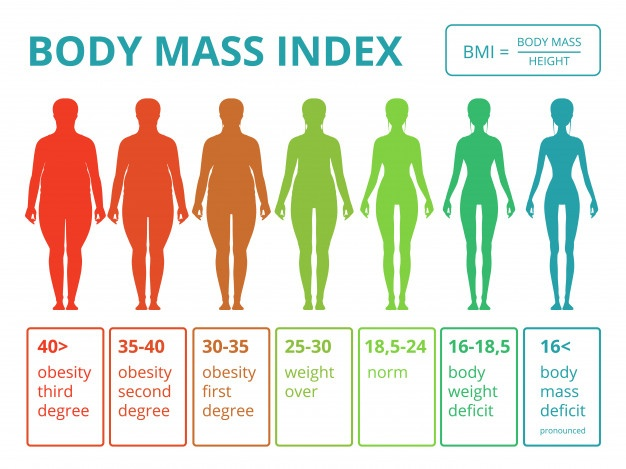

In [14]:
Image('bmi classification.jpg', width= 700)

In [15]:
df1[df1['bmi'] > 65]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,545,Male,42,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
928,41097,Female,23,1,0,No,Private,Urban,70.03,78.0,smokes,0
1559,37759,Female,53,0,0,Yes,Private,Rural,72.63,66.8,Unknown,0
2128,56420,Male,17,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


Nesse primeiro ciclo do nosso projeto, vamos manter esses indíviduos no nosso dataset, mas tendo em mente que possa ser algum erro de digitação e que devemos averiguar se a informação é verídica.

#### 1.6.2. Atributos Categóricos

In [16]:
for i in cat_att.columns:
    print(i)
    print('Possui {} valores únicos'.format(len(df1[i].unique())))
    print('Os valores únicos são: {}'.format(df1[i].unique()))
    print('-'*100)

id
Possui 5110 valores únicos
Os valores únicos são: [ 9046 51676 31112 ... 19723 37544 44679]
----------------------------------------------------------------------------------------------------
gender
Possui 3 valores únicos
Os valores únicos são: ['Male' 'Female' 'Other']
----------------------------------------------------------------------------------------------------
hypertension
Possui 2 valores únicos
Os valores únicos são: [0 1]
----------------------------------------------------------------------------------------------------
heart_disease
Possui 2 valores únicos
Os valores únicos são: [1 0]
----------------------------------------------------------------------------------------------------
ever_married
Possui 2 valores únicos
Os valores únicos são: ['Yes' 'No']
----------------------------------------------------------------------------------------------------
work_type
Possui 5 valores únicos
Os valores únicos são: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_w

## 2.0. FEATURE ENGINEERING

In [17]:
df2= df1.copy()

### 2.1. Mapa Mental de Hipóteses

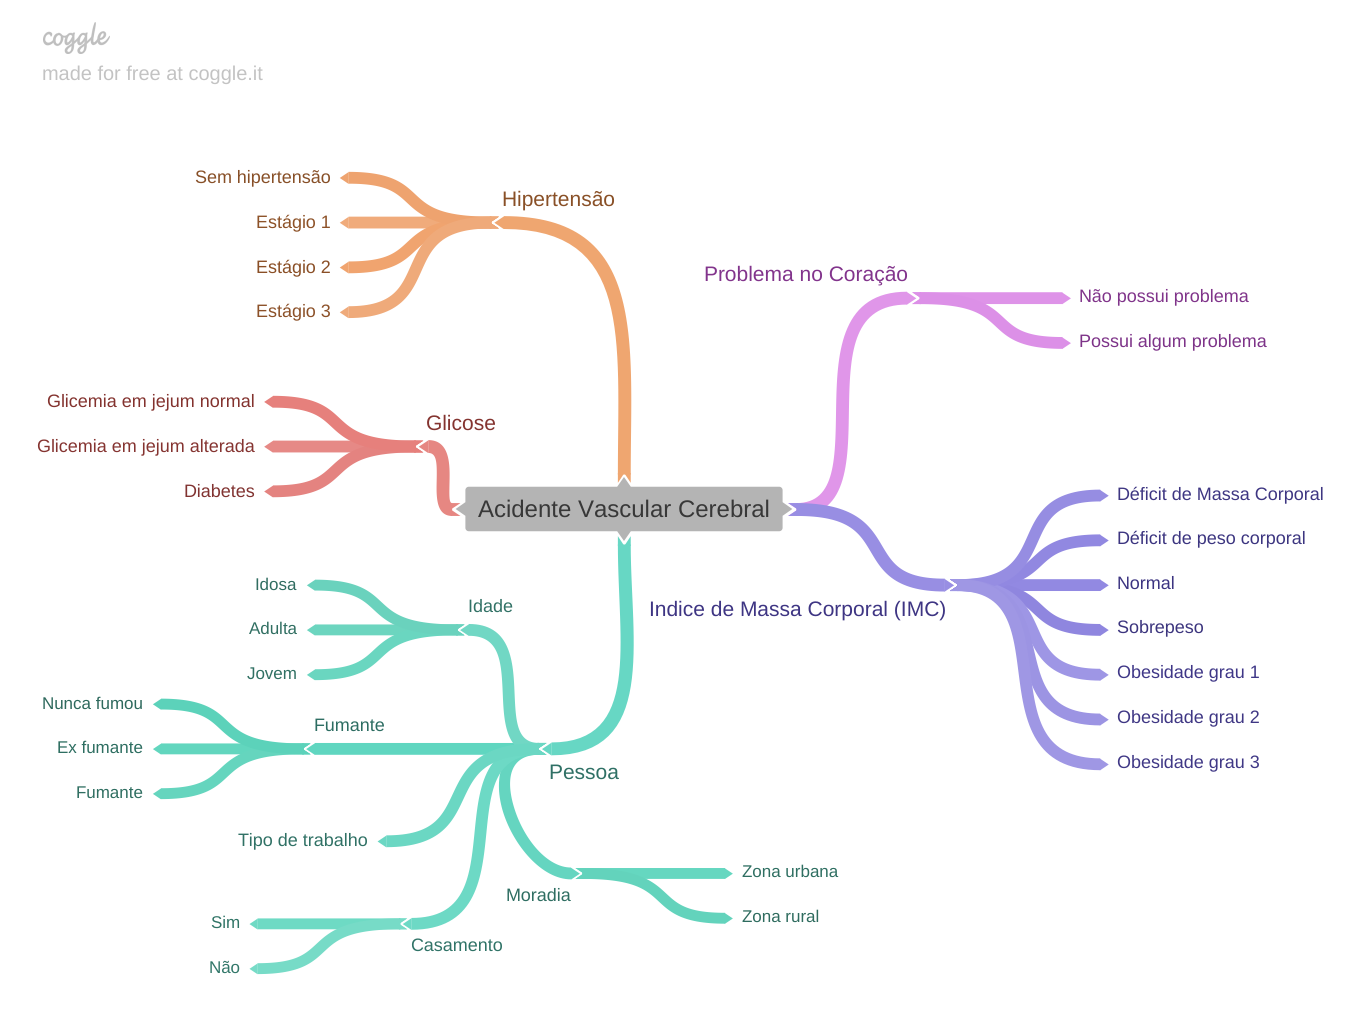

In [18]:
Image('https://raw.githubusercontent.com/rodrigogaf01/Stroke-Prediction/main/MindMapAVC.png')

### 2.2. Lista de Hipóteses

**H1** Homens são mais propensos a ter AVC.

**H2** Quanto mais velho, maior a chance de ter AVC.

**H3** Pessoas com hipertensão tendem a ter AVC.

**H4** Pessoas que não se casaram tendem a ter AVC.

**H5** O tipo de trabalho pode influenciar a tendência de AVC.

**H6** Pessoas que moram nas zonas urbanas tendem a ter mais AVC.

**H7** Quanto maior o Índice de Massa Corporal maior a chance de ter AVC.

**H8** Fumantes possuem mais chance de ter AVC.

**H9** Pessoas com problemas no coração tendem a ter AVC.

**H10** Pessoas com maior índice de glicose no sangue têm mais chance de ter AVC.

### 2.3. Feature Engineering
Vamos criar uma coluna de classificação do ````bmi```` de acordo com a tabela da imagem mencionada na seção 1.6.1.

In [19]:
df2['bmi_class']= df2['bmi'].apply(lambda x: 'Obesity III' if x > 40 else ('Obesity II' if x > 35 else ('Obesity I' if x > 30 else ('Weight Over' if x > 25 else ('Normal' if x > 18.5 else ('Body Weight Deficit' if x > 16 else 'Body Mass Deficit'))))))

## 3.0. FILTRANDO OS DADOS

In [20]:
df3= df2.copy()

### 3.1. Filtragem das Linhas
Não iremos filtrar nenhuma linha.

### 3.2. Filtragem das Colunas
Vamos remover a feature ````id```` pois é um código único para cada pessoa e não será útil para o nosso modelo.

In [21]:
df3.drop(columns= 'id', inplace= True)

## 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [22]:
df4= df3.copy()

### 4.1. Análise Univariada

#### 4.1.1 Variável Resposta

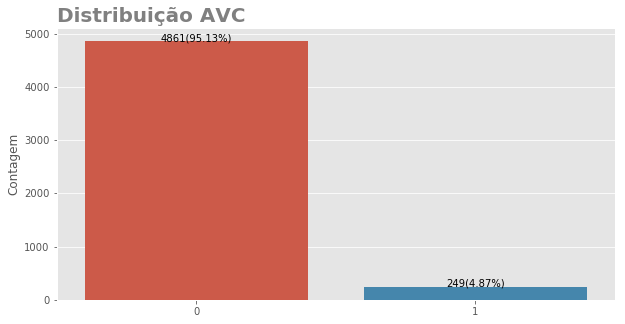

In [23]:
plt.figure(figsize= (10, 5))

ax= sns.countplot(df4['stroke'])
titulo('Distribuição AVC')
valor_grafico(df4, 1)
labels('', 'Contagem')

#### 4.1.2 Variável Numérica Continua

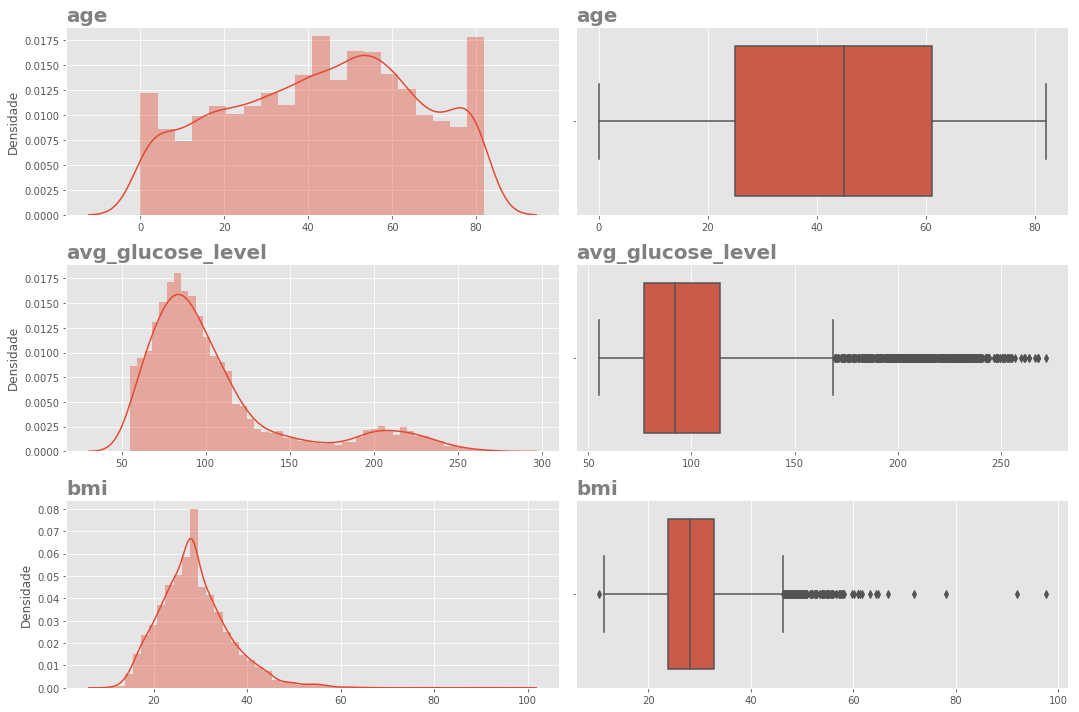

In [24]:
plt.figure(figsize= (15, 10))

n= 1
for i in df4[num_att.columns]:
    plt.subplot(3, 2, n)
    sns.distplot(df4[i])
    titulo(i)
    labels('', 'Densidade')
    n+= 1
    
    plt.subplot(3, 2, n)
    sns.boxplot(x= df4[i])
    titulo(i)
    labels('', '')
    n+= 1

plt.tight_layout()

#### 4.1.3 Variável Categórica

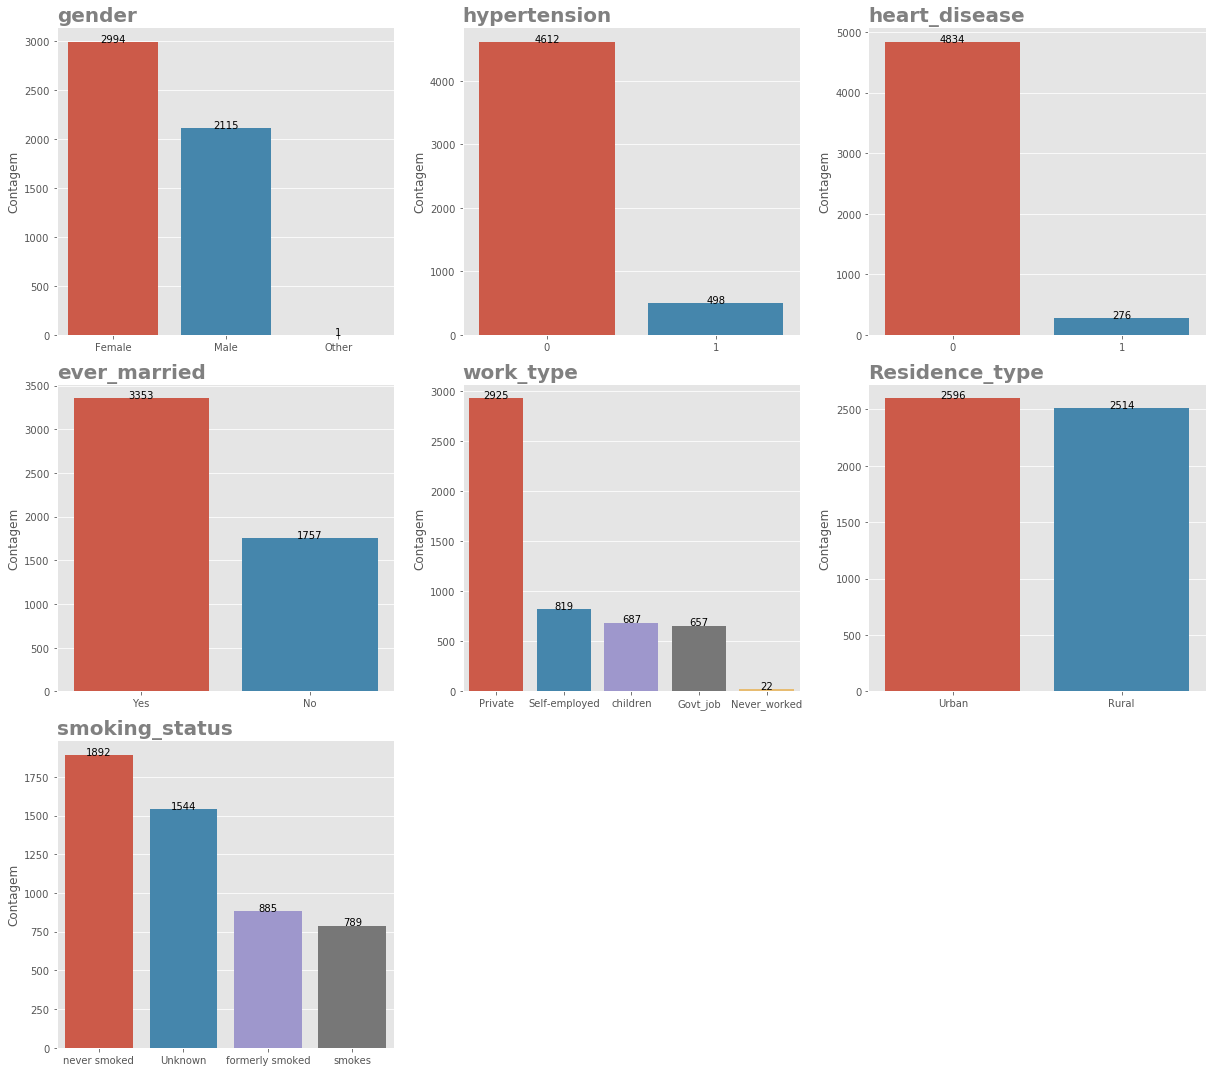

In [25]:
plt.figure(figsize= (17, 15))

lista_cat= ['gender', 'hypertension', 'heart_disease', 'ever_married',
              'work_type', 'Residence_type', 'smoking_status']

n= 1
for i in lista_cat:
    plt.subplot(3, 3, n)
    ax= sns.countplot(df4[i], order= df4[i].value_counts().index)
    valor_grafico(df4)
    titulo(i)
    labels('', 'Contagem')
    
    n+= 1

plt.tight_layout()

### 4.2. Análise Bivariada
**H1** Homens são mais propensos a ter AVC.

**Falso**. A proporção de Stoke em homens e mulheres é praticamente a mesma.

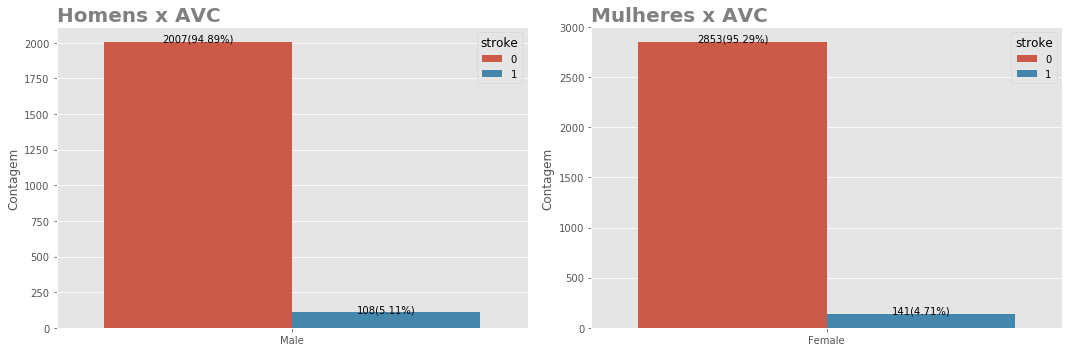

In [26]:
plt.figure(figsize= (15, 5))

homens= df4[df4['gender'] == 'Male']
mulheres= df4[df4['gender'] == 'Female']

# Retirando o gênero 'Other' pois apresenta apenas 1 resultado
#Gráfico 1
plt.subplot(1, 2, 1)
ax= sns.countplot(x= 'gender', data= homens, hue= 'stroke')
titulo('Homens x AVC')
valor_grafico(homens, 1)
labels('', 'Contagem')

#Gráfico 2
plt.subplot(1, 2, 2)
ax= sns.countplot(x= 'gender', data= mulheres, hue= 'stroke')
titulo('Mulheres x AVC')
valor_grafico(mulheres, 1)
labels('', 'Contagem')



plt.tight_layout();

**H2** Quanto mais velho, maior a chance de ter AVC.

**Verdadeiro**. Observamos que o shape das pessoas que têm chance de AVC é inclinada para a maior idade. Confirmada pela matriz de correlação que possui uma correlação positiva, indicando que quanto maior a idade, maior o risco de AVC.

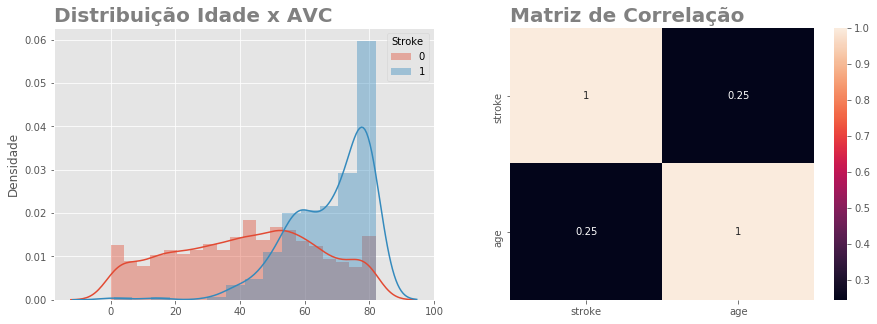

In [27]:
plt.figure(figsize= (15, 5))

stroke0= df4[df4['stroke'] == 0]
stroke1= df4[df4['stroke'] == 1]

plt.subplot(1, 2, 1)
sns.distplot(stroke0['age'], label= '0')
sns.distplot(stroke1['age'], label= '1')
titulo('Distribuição Idade x AVC ')
plt.legend(title= 'Stroke')
labels('', 'Densidade')

plt.subplot(1, 2, 2)
sns.heatmap(df4[['stroke', 'age']].corr(), annot= True)
titulo('Matriz de Correlação')

**H3** Pessoas com hipertensão tendem a ter AVC.

**Verdadeiro**. Observamos que a probabilidade de AVC nas pessoas hipertensas é 10% maior das que não são.

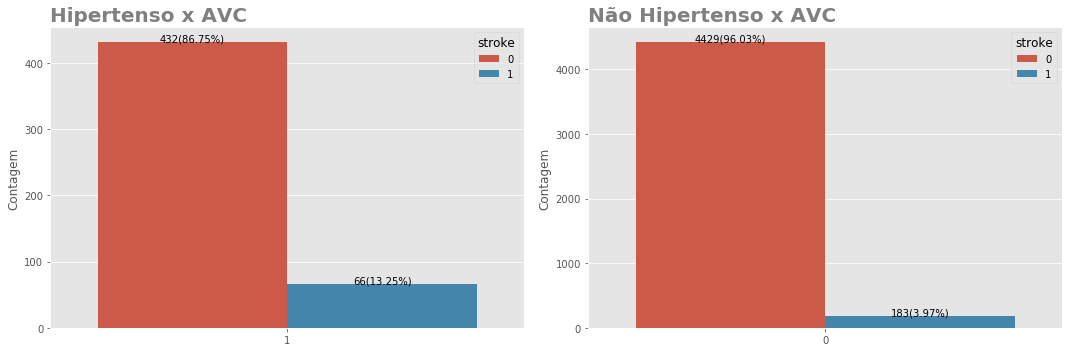

In [28]:
plt.figure(figsize= (15, 5))

hipertenso= df4[df4['hypertension'] == 1]
naohipertenso= df4[df4['hypertension'] == 0]


plt.subplot(1, 2, 1)
ax= sns.countplot(x= 'hypertension', data= hipertenso, hue= 'stroke')
titulo('Hipertenso x AVC')
valor_grafico(hipertenso, 1)
labels('', 'Contagem')

#Gráfico 2
plt.subplot(1, 2, 2)
ax= sns.countplot(x= 'hypertension', data= naohipertenso, hue= 'stroke')
titulo('Não Hipertenso x AVC')
valor_grafico(naohipertenso, 1)
labels('', 'Contagem')


plt.tight_layout();

**H4** Pessoas que não se casaram tendem a ter AVC.

**Falso**. Não pôde comprovar que o casamento interfere na tendência da pessoa ter AVC, pois a proporção de AVC nas duas classes são bem próximas.

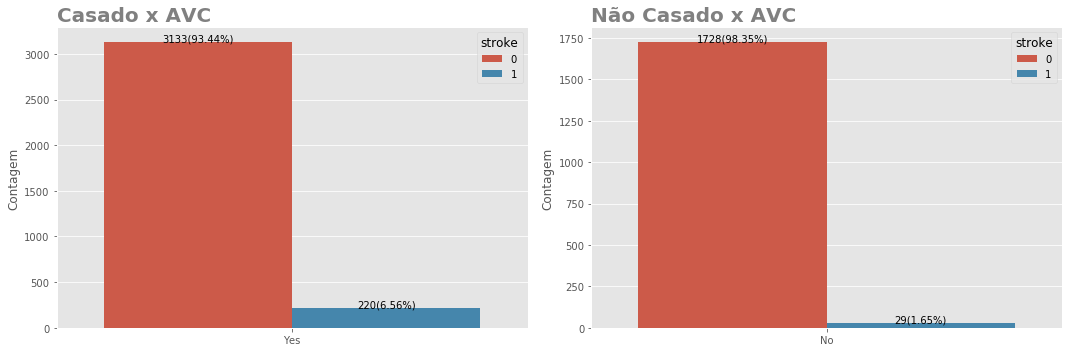

In [29]:
plt.figure(figsize= (15, 5))

casadas= df4[df4['ever_married'] == 'Yes']
naocasadas= df4[df4['ever_married'] == 'No']


plt.subplot(1, 2, 1)
ax= sns.countplot(x= 'ever_married', data= casadas, hue= 'stroke')
titulo('Casado x AVC')
valor_grafico(casadas, 1)
labels('', 'Contagem')

#Gráfico 2
plt.subplot(1, 2, 2)
ax= sns.countplot(x= 'ever_married', data= naocasadas, hue= 'stroke')
titulo('Não Casado x AVC')
valor_grafico(naocasadas, 1)
labels('', 'Contagem')


plt.tight_layout();

**H5** O tipo de trabalho pode influenciar a tendência de AVC.

**Falso**. A proporção que cada um tipo de trabalho influência no Churn é bem parecida, com a excessão dos tipos Never_worked e children pois o primeiro contém poucos dados(22) e o segundo pelo o que provamos na hipótese H2 que a idade influencia no AVC.

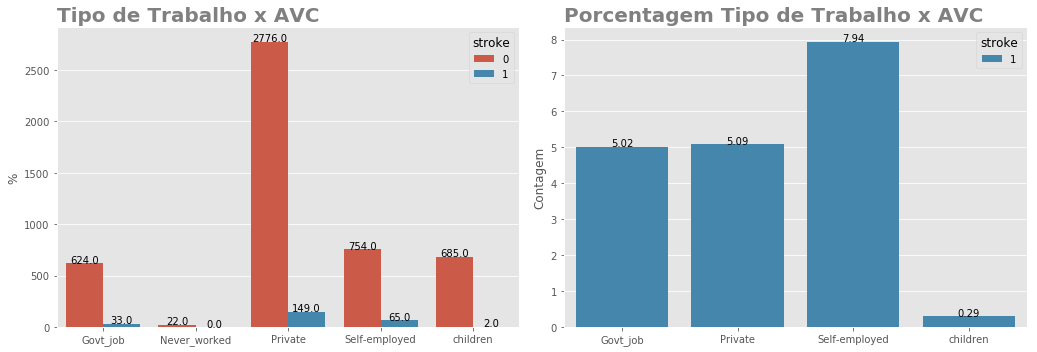

In [30]:
plt.figure(figsize= (15, 5))

aux1= df4[['stroke', 'work_type', 'gender']].groupby(['work_type', 'stroke']).count().reset_index()
aux1= aux1.append({'work_type': 'Never_worked', 'stroke': 1, 'gender': 0},ignore_index= True)
aux1.rename(columns= {'gender': 'count'}, inplace= True)


plt.subplot(1, 2, 1)
ax= sns.barplot(x= 'work_type', y= 'count', data= aux1, hue= 'stroke')
titulo('Tipo de Trabalho x AVC')
valor_grafico(data= df4)
labels('', '%')


plt.subplot(1, 2, 2)

aux2= df4[['work_type', 'stroke', 'gender']].groupby(['work_type', 'stroke']).count().reset_index()
aux2.rename(columns= {'gender': 'count'}, inplace= True)
aux3= aux2[aux2['stroke'] == 1]
aux4= df4[['work_type', 'stroke']].groupby('work_type').count().reset_index()
aux3= pd.merge(aux3, aux4, on= 'work_type')
aux3['%']= (aux3['count']/aux3['stroke_y']*100).round(2)
aux3.rename(columns= {'stroke_x': 'stroke', 'stroke_y': 'total'}, inplace= True)


ax= sns.barplot(x= 'work_type', y= '%', data= aux3, hue= 'stroke', palette= ['#348ABD'])
titulo('Porcentagem Tipo de Trabalho x AVC')
valor_grafico(aux3)
labels('', 'Contagem')


plt.tight_layout();

**H6** Pessoas que moram nas zonas urbanas tendem a ter mais AVC.

**Falso**. Observamos que a proporção entre as duas zonas em relação ao AVC é muito parecida, fazendo com que não possamos confirmar a hipótese.

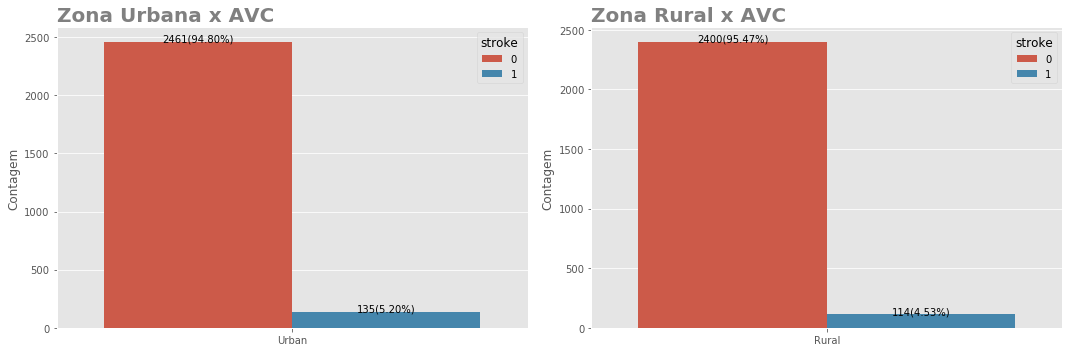

In [31]:
plt.figure(figsize= (15, 5))

urbana= df4[df4['Residence_type'] == 'Urban']
rural= df4[df4['Residence_type'] == 'Rural']

#Gráfico 1
plt.subplot(1, 2, 1)
ax= sns.countplot(x= 'Residence_type', data= urbana, hue= 'stroke')
titulo('Zona Urbana x AVC')
valor_grafico(urbana, 1)
labels('', 'Contagem')

#Gráfico 2
plt.subplot(1, 2, 2)
ax= sns.countplot(x= 'Residence_type', data= rural, hue= 'stroke')
titulo('Zona Rural x AVC')
valor_grafico(rural, 1)
labels('', 'Contagem')


plt.tight_layout();

**H7** Quanto maior o Índice de Massa Corporal maior a chance de ter AVC.

**Falso**. Observamos que os shapes das pessoas que tem ou não stoke são bem parecidas. Fato que é comprovado pela matriz de correlação quase 0.

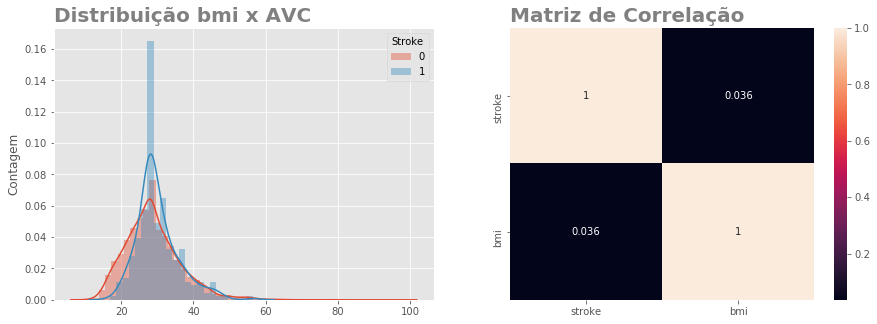

In [32]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 2, 1)
sns.distplot(stroke0['bmi'], label= '0')
sns.distplot(stroke1['bmi'], label= '1')
plt.legend(title= 'Stroke')
titulo('Distribuição bmi x AVC')
labels('', 'Contagem')

plt.subplot(1, 2, 2)
sns.heatmap(df4[['stroke', 'bmi']].corr(), annot= True)
titulo('Matriz de Correlação')

**H8** Fumantes possuem mais chance de ter AVC.

**Falso**. Observamos que a porcentagem de cada um dos tipos de fumantes não é muito diferente, fazendo com que não possamos afirmar a hipótese.

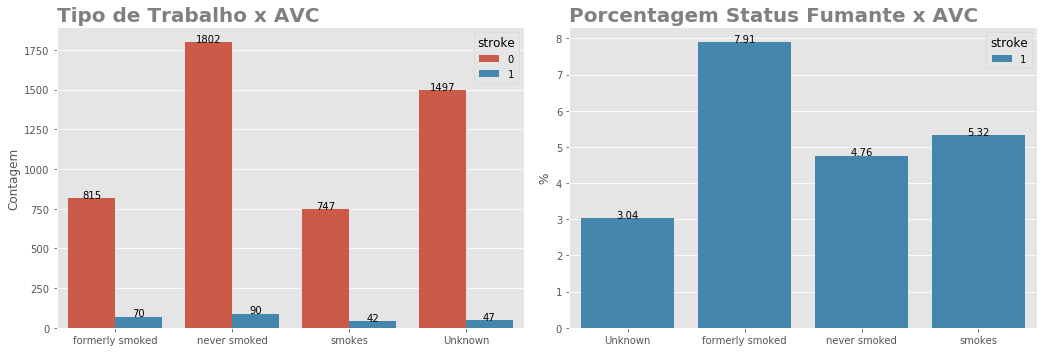

In [33]:
plt.figure(figsize= (15, 5))


plt.subplot(1, 2, 1)
ax= sns.countplot(x= 'smoking_status', data= df4, hue= 'stroke')
titulo('Tipo de Trabalho x AVC')
valor_grafico(data= df4)
labels('', 'Contagem')


plt.subplot(1, 2, 2)

aux2= df4[['smoking_status', 'stroke', 'gender']].groupby(['smoking_status', 'stroke']).count().reset_index()
aux2.rename(columns= {'gender': 'count'}, inplace= True)
aux3= aux2[aux2['stroke'] == 1]
aux4= df4[['smoking_status', 'stroke']].groupby('smoking_status').count().reset_index()
aux3= pd.merge(aux3, aux4, on= 'smoking_status')
aux3['%']= (aux3['count']/aux3['stroke_y']*100).round(2)
aux3.rename(columns= {'stroke_x': 'stroke', 'stroke_y': 'total'}, inplace= True)


ax= sns.barplot(x= 'smoking_status', y= '%', data= aux3, hue= 'stroke', palette= ['#348ABD'])
titulo('Porcentagem Status Fumante x AVC')
valor_grafico(aux3)
labels('', '%')

plt.tight_layout();

**H9** Pessoas com problemas no coração tendem a ter AVC.

**Verdadeiro**. Apesar de termos poucos dados de pessoas com problemas de coração, observamos que possui uma porcentagem expressivamente maior do que as pessoas que não têm problema cardíaco.

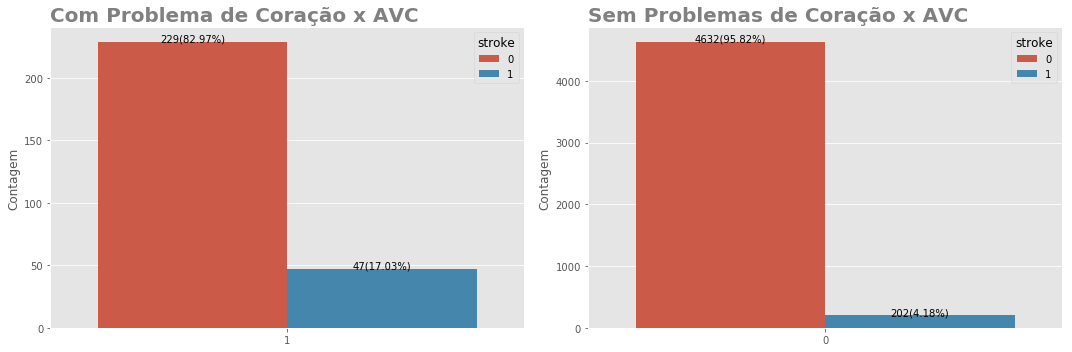

In [34]:
plt.figure(figsize= (15, 5))

probcoracao= df4[df4['heart_disease'] == 1]
semprobcoracao= df4[df4['heart_disease'] == 0]


#Gráfico 1
plt.subplot(1, 2, 1)
ax= sns.countplot(x= 'heart_disease', data= probcoracao, hue= 'stroke')
titulo('Com Problema de Coração x AVC')
valor_grafico(probcoracao, 1)
labels('', 'Contagem')

#Gráfico 2
plt.subplot(1, 2, 2)
ax= sns.countplot(x= 'heart_disease', data= semprobcoracao, hue= 'stroke')
titulo('Sem Problemas de Coração x AVC')
valor_grafico(semprobcoracao, 1)
labels('', 'Contagem')


plt.tight_layout();

**H10** Pessoas com maior índice de glicose no sangue têm mais chance de ter AVC.

**Verdadeiro**. Observamos que o formato dos shapes das pessoas sem e com AVC em função a esse índice são muito parecidas, porém observamos que quando o stroke é 1 a densidade fica o dobro. O fato se confirma na matriz de correlação onde a correlação é bem fraca porém existe.

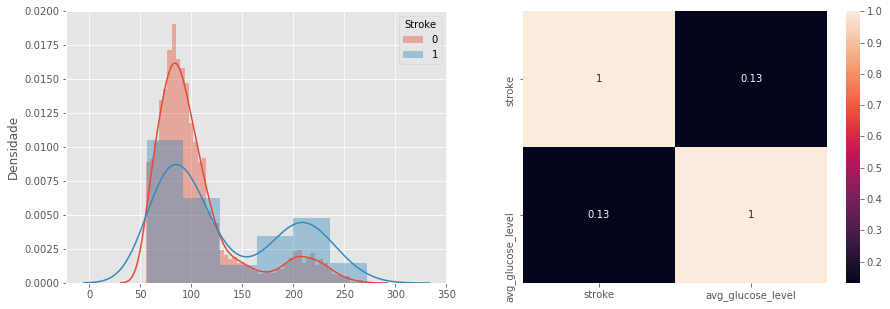

In [35]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 2, 1)
sns.distplot(stroke0['avg_glucose_level'], label= '0')
sns.distplot(stroke1['avg_glucose_level'], label= '1')
plt.legend(title= 'Stroke')
labels('', 'Densidade')

plt.subplot(1, 2, 2)
sns.heatmap(df4[['stroke', 'avg_glucose_level']].corr(), annot= True)

### 4.3. Análise Multivariada

#### 4.3.1. Atributos Numéricos

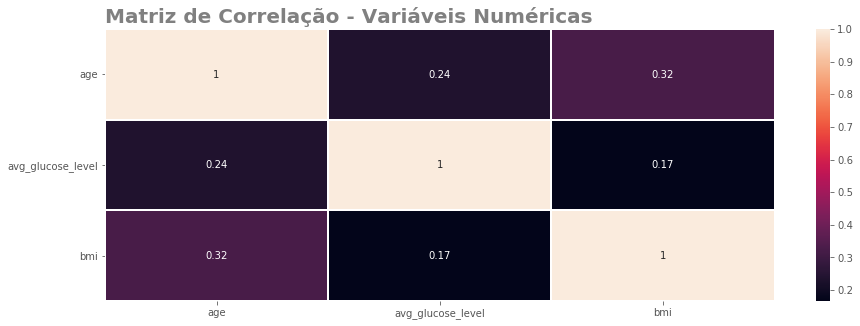

In [36]:
plt.figure(figsize= (15, 5))

sns.heatmap(num_att.corr(), annot= True, linewidth= 1)
titulo('Matriz de Correlação - Variáveis Numéricas')

#### 4.3.2. Atributos Categóricos

In [37]:
cat_att2= cat_att.drop(columns= 'id')

rows= []

for i in cat_att2:
    col = []
    for j in cat_att2 :
        cramers =cramer_v(cat_att2[i], cat_att2[j])
        col.append(round(cramers,2)) 
    rows.append(col)
    
cramers_results = np.array(rows)
a = pd.DataFrame(cramers_results, columns = cat_att2.columns, index =cat_att2.columns)

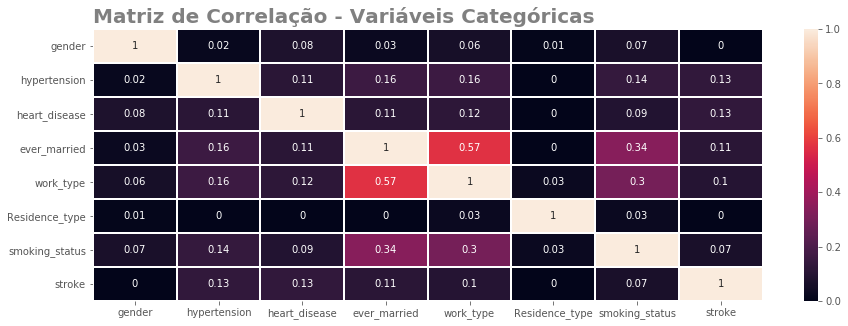

In [38]:
plt.figure(figsize= (15, 5))

sns.heatmap(a, annot= True, linewidth= 1)
titulo('Matriz de Correlação - Variáveis Categóricas')

## 5.0. PREPARAÇÃO DOS DADOS

In [39]:
df5= df4.copy()

### 5.1. Normalização
Como podemos observar na seção 4.1.2, não apresentamos nenhuma variável numérica com distribuição normal, então não faremos a normalização dos dados.

### 5.2. Reescaling
Primeiro vamos selecionar as variáveis numéricas para depois observar as features que possuem outliers e as que não possuem para aplicar diferentes métodos de reescaling, sendo o RobustScaler para o primeiro e o MinMaxScaler para o segundo.

De acordo com a seção 4.1.2 , a feature ````age```` não têm outliers então usaremos o método MinMaxScaler, entretando as features ````avg_glucose_level e bmi```` apresentam muitos, então usaremos o RobustScaler.

In [40]:
# MinMaxScaler
mm= MinMaxScaler()

df5['age']= mm.fit_transform(df5[['age']])

# RobustScar
rb= RobustScaler()

df5['avg_glucose_level']= rb.fit_transform(df5[['avg_glucose_level']])
df5['bmi']= rb.fit_transform(df5[['bmi']])

In [41]:
df5.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_class
0,Male,0.817073,0,1,Yes,Private,Urban,3.712987,0.944444,formerly smoked,1,Obesity II
1,Female,0.743902,0,0,Yes,Self-employed,Rural,2.994300,0.000000,never smoked,1,Weight Over
2,Male,0.975610,0,1,Yes,Private,Rural,0.380920,0.488889,never smoked,1,Obesity I
3,Female,0.597561,0,0,Yes,Private,Urban,2.153481,0.700000,smokes,1,Obesity I
4,Female,0.963415,1,0,Yes,Self-employed,Rural,2.231917,-0.455556,never smoked,1,Normal


### 5.3. Transformação 

#### 5.3.1. Encoding

#### Label Enconder ####

LabelEncoder é uma classe de utilitário para ajudar a normalizar rótulos de forma que contenham apenas valores entre 0 e n_classes-1. Pode ser usado para transformar rótulos não numéricos em rótulos numéricos.

#### One Hot Encoder ####

Esse tipo de codificação pode ser obtido com o OneHotEncoder e get_dummies, que transforma cada recurso categórico com valores possíveis de n_categories em recursos binários de n-categorias, sendo um deles 1 e todos os outros 0.

#### Ordinal Encoder #### 

Para converter recursos categóricos em códigos inteiros, podemos usar o OrdinalEncoder. Este estimador transforma cada recurso categórico em um novo recurso de números inteiros (0 a n_categories - 1) conforme ordenado.

Vamos pegar as features que são objects e transforma-las em numéricas através dos métodos abaixo:
- gender: Label Enconding
- ever_married: Label Enconding
- work_type: Label Enconding
- Residence_type: Label Enconding
- smoking_status: Ordinal Encoding
- bmi_class: Ordinal Encoding

In [42]:
# LabelEncoder
lb= LabelEncoder()

df5['gender']= lb.fit_transform(df5[['gender']])
df5['ever_married']= lb.fit_transform(df5[['ever_married']])
df5['work_type']= lb.fit_transform(df5[['work_type']])
df5['Residence_type']= lb.fit_transform(df5[['Residence_type']])


# OrdinalEncoder
map_smoking= {'never smoked': 0, 'formerly smoked': 1, 'Unknown': 2, 'smokes': 3}
map_bmi= {'Body Mass Deficit': 0, 'Body Weight Deficit': 1, 'Normal': 2, 'Weight Over': 3, 'Obesity I': 4, 'Obesity II': 5, 'Obesity III': 6}

df5['smoking_status']= df5['smoking_status'].map(map_smoking)
df5['bmi_class']= df5['bmi_class'].map(map_bmi)

In [43]:
df5.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_class
0,1,0.817073,0,1,1,2,1,3.712987,0.944444,1,1,5
1,0,0.743902,0,0,1,3,0,2.994300,0.000000,0,1,3
2,1,0.975610,0,1,1,2,0,0.380920,0.488889,0,1,4
3,0,0.597561,0,0,1,2,1,2.153481,0.700000,3,1,4
4,0,0.963415,1,0,1,3,0,2.231917,-0.455556,0,1,2


In [44]:
oe= OrdinalEncoder()

## 6.0. SELEÇÃO DE FEATURES

In [45]:
df6= df5.copy()

### 6.1. Balanceando as Classes
Conforme observado anteriormente, a nossa variável resposta(stroke) apresenta um desbalanceamento nos seus dados, contendo duas respostas onde uma delas representa apenas 5% do total.

Nesse projeto utilizaremos o método **SMOTE** que basicamente funciona selecionando exemplos que estão próximos no espaço do recurso, desenhando uma linha entre os exemplos no espaço do recurso e desenhando uma nova amostra em um ponto ao longo dessa linha. Caso queira saber mais sobre esse método [clique aqui](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

In [46]:
# Separando dados em X e Y
x= df6.drop(columns= 'stroke')
y= df6['stroke']

In [47]:
# Semente global
seed= 123
np.random.seed(seed)

smote= SMOTE()

x, y= smote.fit_resample(x, y)

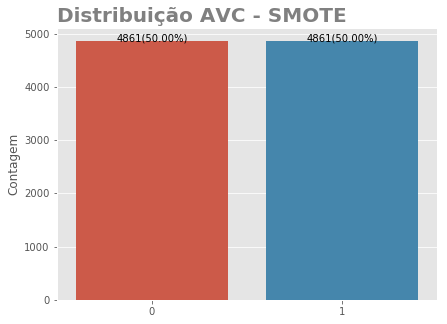

In [48]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 2, 1)
ax= sns.countplot(y)
titulo('Distribuição AVC - SMOTE')
valor_grafico(y, 1)
labels('', 'Contagem')

### 6.2. Separar o Dataset em Treino e Teste

In [49]:
np.random.seed(seed)

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.3, shuffle= y)

### 6.3. Random Forest
RandomForest possui é um modelo que pode ser usado como seleção de features pois retorna as colunas mais relevantes de acordo com seu método.

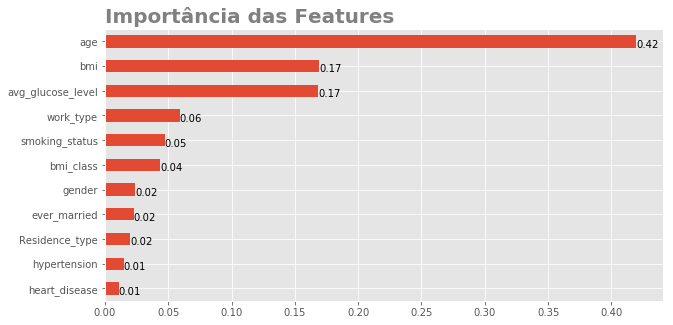

In [50]:
# Definindo modelo
rf_model = RandomForestClassifier(n_jobs = -1)
rf_model.fit(x_train, y_train)

# Vendo as features selecionadas
feat_importances = pd.Series(rf_model.feature_importances_, index=x.columns)

# Gráfico
plt.figure(figsize= (10, 5))
ax= feat_importances.sort_values().plot(kind='barh')
titulo('Importância das Features')

# Valores no Gráfico
for patch in ax.patches:
    width= patch.get_width()
    left_coord= patch.get_y()
    
    ax.text(width, left_coord, '{:.2f}'.format(width))

### 6.4. Features Selecionadas
Nesse primeiro ciclo do projeto, vamos selecionar todas as features.

## 7.0. MACHINE LEARNING

Após entendermos melhor nossos dados, é hora de utilizarmos Machine Learning para fazer previsões que podem nos ajudar a prever a tendência de uma pessoa ter AVC.

Para isso, utilizaremos 6 modelos diferentes de Machine Learning:

>* RandomForest
>* DecisionTree
>* KNeighbors
>* SVC
>* AdaBoost
>* XGBoost


### Validação Cruzada(Cross-Validation)

Para o resultado ser fiel a realidade e não ficar refém da sorte de uma aleatóriedade, utilizaremos validação cruzada. Para saber mais como funciona essa técnica, leia [este artigo](https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/#:~:text=A%20valida%C3%A7%C3%A3o%20cruzada%20%C3%A9%20uma,da%20modelagem%20%C3%A9%20a%20predi%C3%A7%C3%A3o.).

Nesse projeto iremos utilizar o KFold com o numero de folders igual a 10.

In [51]:
models= []

models.append(('RandomForest', RandomForestClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('KNeighbors', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('XGBoost', XGBClassifier(eval_metric='mlogloss')))

models

[('RandomForest', RandomForestClassifier()),
 ('DecisionTree', DecisionTreeClassifier()),
 ('KNeighbors', KNeighborsClassifier()),
 ('SVC', SVC()),
 ('AdaBoost', AdaBoostClassifier()),
 ('XGBoost',
  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None,
                eval_metric='mlogloss', gamma=None, gpu_id=None,
                importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=None))]

In [52]:
np.random.seed(seed)

names_accuracy= []
results_accuracy= []

for name, model in models:
    kfold= KFold(n_splits= 10, shuffle= True)
    cv= cross_val_score(estimator= model, X= x_train, y= y_train, cv= kfold, scoring= 'accuracy')*100
    print('{:12} : Acurácia Média {:.2f}% - Desvio Padrão {:.2f}%'.format(name, cv.mean(), cv.std()))
    
    names_accuracy.append(name)
    results_accuracy.append(cv)

RandomForest : Acurácia Média 92.84% - Desvio Padrão 0.97%
DecisionTree : Acurácia Média 88.26% - Desvio Padrão 1.67%
KNeighbors   : Acurácia Média 85.82% - Desvio Padrão 0.77%
SVC          : Acurácia Média 82.70% - Desvio Padrão 1.10%
AdaBoost     : Acurácia Média 82.73% - Desvio Padrão 1.84%
XGBoost      : Acurácia Média 95.55% - Desvio Padrão 0.71%


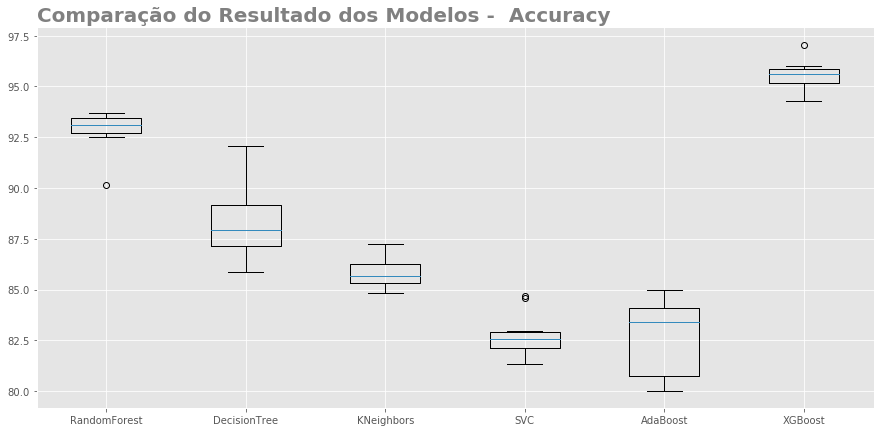

In [53]:
plt.figure(figsize= (15, 7))

plt.boxplot(results_accuracy, labels= names_accuracy)
titulo('Comparação do Resultado dos Modelos -  Accuracy');

In [54]:
np.random.seed(seed)

names_recall= []
results_recall= []

for name, model in models:
    kfold= KFold(n_splits= 10, shuffle= True)
    cv= cross_val_score(estimator= model, X= x_train, y= y_train, cv= kfold, scoring= 'recall')*100
    print('{:12} : Recall Médio {:.2f}%'.format(name, cv.mean(), cv.std()))
    
    names_recall.append(name)
    results_recall.append(cv)

RandomForest : Recall Médio 96.31%
DecisionTree : Recall Médio 89.53%
KNeighbors   : Recall Médio 95.60%
SVC          : Recall Médio 89.37%
AdaBoost     : Recall Médio 88.03%
XGBoost      : Recall Médio 95.23%


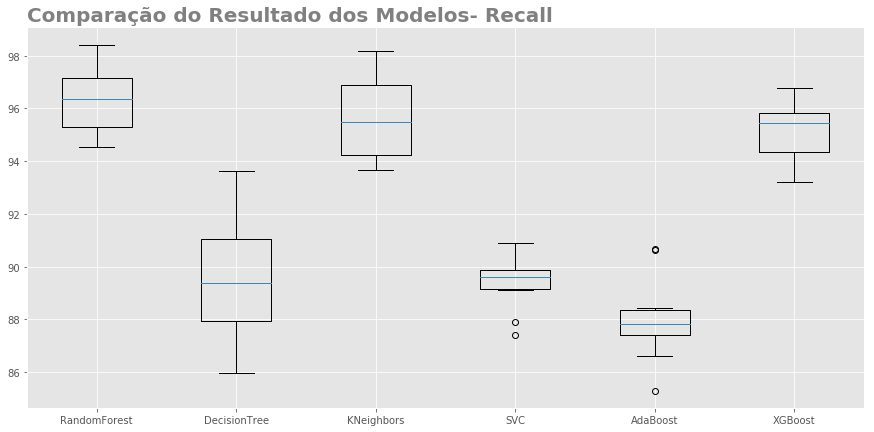

In [55]:
plt.figure(figsize= (15, 7))

plt.boxplot(results_recall, labels= names_recall)
titulo('Comparação do Resultado dos Modelos- Recall');

### 7.1. Resultados de Treino

Observamos que os modelos RandomForest e XGBoost foram os dois modelos que se performaram melhor nos dados de treino, chegando um uma acurácia de 92% e 95% respectivamente, o que é um resultado excelente, porém pode ter acontecido o que chamamos de **OVERFITTING**.

Um cenário de overfitting ocorre quando, nos dados de treino, o modelo tem um desempenho excelente, porém quando utilizamos os dados de teste o resultado é ruim. Então, vamos avaliar os modelos citados para ver se performam tão bem nos dados de treino.

Vale a pena ressaltar que o modelo KNeighbors obteve um recall muito bom, ficando atrás apenas do Random Forest.

### 7.2. Dados de Teste
Nessa etapa, vamos pegar os modelos Random Forest e XGBoost para testá-los com os dados de teste para observar se a acurácia e o recall se mantém com ótimos resultados.

#### 7.2.1. Random Forest

In [56]:
rf= RandomForestClassifier()

rf.fit(x_train, y_train)
y_pred_rf= rf.predict(x_test)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1472
           1       0.89      0.96      0.92      1445

    accuracy                           0.92      2917
   macro avg       0.92      0.92      0.92      2917
weighted avg       0.92      0.92      0.92      2917



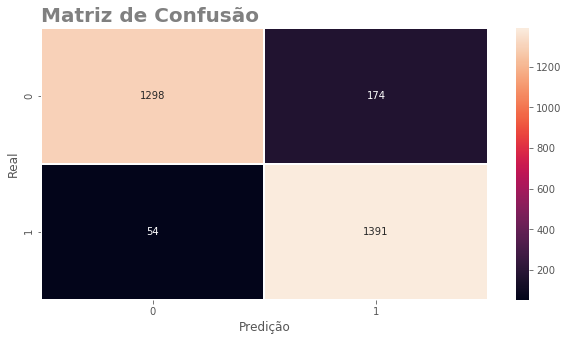

In [57]:
plt.figure(figsize= (10, 5))

print(classification_report(y_test, y_pred_rf))

cm= confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot= True, linewidths= 1, fmt= '')
titulo('Matriz de Confusão')
labels('Predição', 'Real');

#### 7.2.2. XGBoost

In [58]:
xg= XGBClassifier(eval_metric='mlogloss')

xg.fit(x_train, y_train)
y_pred_xg= xg.predict(x_test)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1472
           1       0.94      0.96      0.95      1445

    accuracy                           0.95      2917
   macro avg       0.95      0.95      0.95      2917
weighted avg       0.95      0.95      0.95      2917



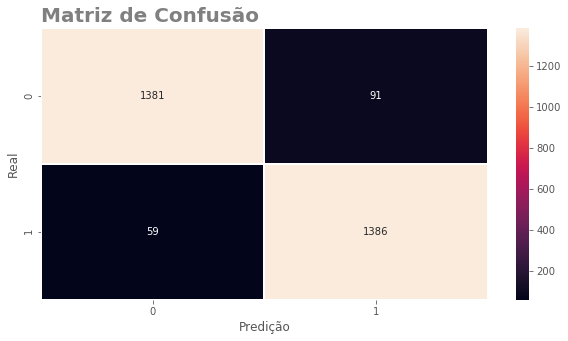

In [59]:
plt.figure(figsize= (10, 5))

print(classification_report(y_test, y_pred_xg))

cm= confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cm, annot= True, linewidths= 1, fmt= '')
titulo('Matriz de Confusão')
labels('Predição', 'Real');

## 8.0. INTERPRETANDO OS RESULTADOS

### 8.1. Conclusões

- Os nossos dois modelos tiveram acurácia e recall acima dos 90% tanto nos dados de treino quanto nos dados de teste.

- O modelo XGBoost teve um desempenho superior ao de Random Forest em 3%, o que pode significar muito quando estamos lidando com a saúde das pessoas. Então esse seria o modelo que botariamos em produção.

- Temos que relembrar que no nosso dataset original a variável alvo(stroke) estava desbalanceada e tivemos que criar dados artificiais com o método SMOTE.

### 8.2. Próximos Passos

- Obter mais dados para nosso modelo conseguir treinar mais e encontrar novos padrões.
- Balancer os dados da feature stroke para não ser necessário criar dados artificialmente com SMOTE.
- Reconstruir a feature engineering e encoding para encontrar novas variáveis que o modelo veja com maior importância.
- Maximizar os Hiperparâmetros a fim de melhorar ainda mais a performance do modelo.
- Botar o modelo em produção para que outras pessoas possam utilizá-lo.